# WildfireAI API Quickstart (Python)

This notebook shows how to use the WildfireAI REST API with a API key to:
- Retrieve devices
- Get latest records organized by aliases
- Query historical records per sensor (by sensor number or alias) and record type
- Retrieve images by ID

Helpful references:
- Interactive API explorer: [wildfireai.com/api](https://wildfireai.com/api)
- Create and manage API keys: [wildfireai.com/portal](https://wildfireai.com/portal)
- API specification (OpenAPI YAML): [wildfireai.com/api-yaml](https://wildfireai.com/api-yaml)

Authentication:
- Generate an API key in the Portal.
- Use it as a Bearer token in the `Authorization` header: 
```
Authorization: Bearer <your_api_key_here>
```

You can set an environment variable before starting the notebook kernel:

```bash
export WILDFIREAI_API_KEY="<your_api_key_here>"
```

Or start the notebook and enter the key when prompted.


In [1]:
# Install/import dependencies
try:
    import requests
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
except Exception:
    import sys

    !{sys.executable} -m pip -q install requests
    import requests

    !{sys.executable} -m pip -q install matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates


from typing import Any, Dict, Optional, Union
from datetime import datetime
from IPython.display import display, Image as IPyImage
import json
import os


In [2]:
# Configuration: base URL and API key
from getpass import getpass

API_ORIGIN = "https://wildfireai.com"  # Domain
BASE_URL = f"{API_ORIGIN}".rstrip("/")

API_KEY = os.getenv("WILDFIREAI_API_KEY") or ""
if not API_KEY:
    # Secure prompt in case env var is not set
    API_KEY = getpass("Enter your WildfireAI API key (input hidden): ")

session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {API_KEY}",
    "User-Agent": "WildfireAI-API-Quickstart/1.0"
})

print("BASE_URL:", BASE_URL)



BASE_URL: https://wildfireai.com


In [ ]:
# List devices and pick one
PAGE_SIZE = 50
all_devices: list[dict] = []
page = 1
while True:
    response = session.get(
        f"{BASE_URL}/devices", params={"page": page, "limit": PAGE_SIZE}
    )
    response.raise_for_status()
    data = response.json()
    if not data.get("data"):
        break
    all_devices.extend(data["data"])
    # Stop if we've consumed all pages
    if data.get("pageCount") and page >= data["pageCount"]:
        break
    page += 1

print(f"Fetched {len(all_devices)} devices. Printing first 3:")
print(json.dumps(all_devices[:3], indent=2))

DEVICE_ID = None  # Set manually if needed

if not DEVICE_ID:
    device_id = all_devices[0]["id"]
    print("Using first device's deviceId:", device_id)


Fetched 5 devices. Printing first 3:
[
  {
    "id": "c0lm7ymakpqg",
    "info": "3"
  },
  {
    "id": "5jbg2zihgcg1",
    "info": "7"
  },
  {
    "id": "q51evp1hyqxf",
    "info": "8"
  }
]
Using first device's deviceId: c0lm7ymakpqg


Keys: ['navigation', 'detection', 'gas', 'wind', 'air_quality', 'power', 'camera_a', 'camera_b', 'infrared_camera_a', 'infrared_camera_b']
[
  {
    "alias": "navigation",
    "records": [
      {
        "id": "C0aDMuQ8TTCC7LSUJCAT",
        "type": "gps",
        "timeRecorded": "2025-07-29T20:14:47.905Z",
        "sensorNo": 10,
        "deviceId": "c0lm7ymakpqg",
        "gps": {
          "latitude": 37.16601,
          "longitude": -121.96301,
          "altitude": 578,
          "quality": 1,
          "numberOfSatellites": 6,
          "HDOP": 1.4
        },
        "evidences": [],
        "claims": []
      },
      {
        "id": "m7E938XdbAlvU9aexb2U",
        "type": "event",
        "timeRecorded": "2025-02-08T15:38:35.066Z",
        "sensorNo": 10,
        "deviceId": "c0lm7ymakpqg",
        "event": {
          "eventCode": "S201",
          "originalType": "gps"
        },
        "evidences": [],
        "claims": []
      }
    ]
  },
  {
    "alias": "detection",
 

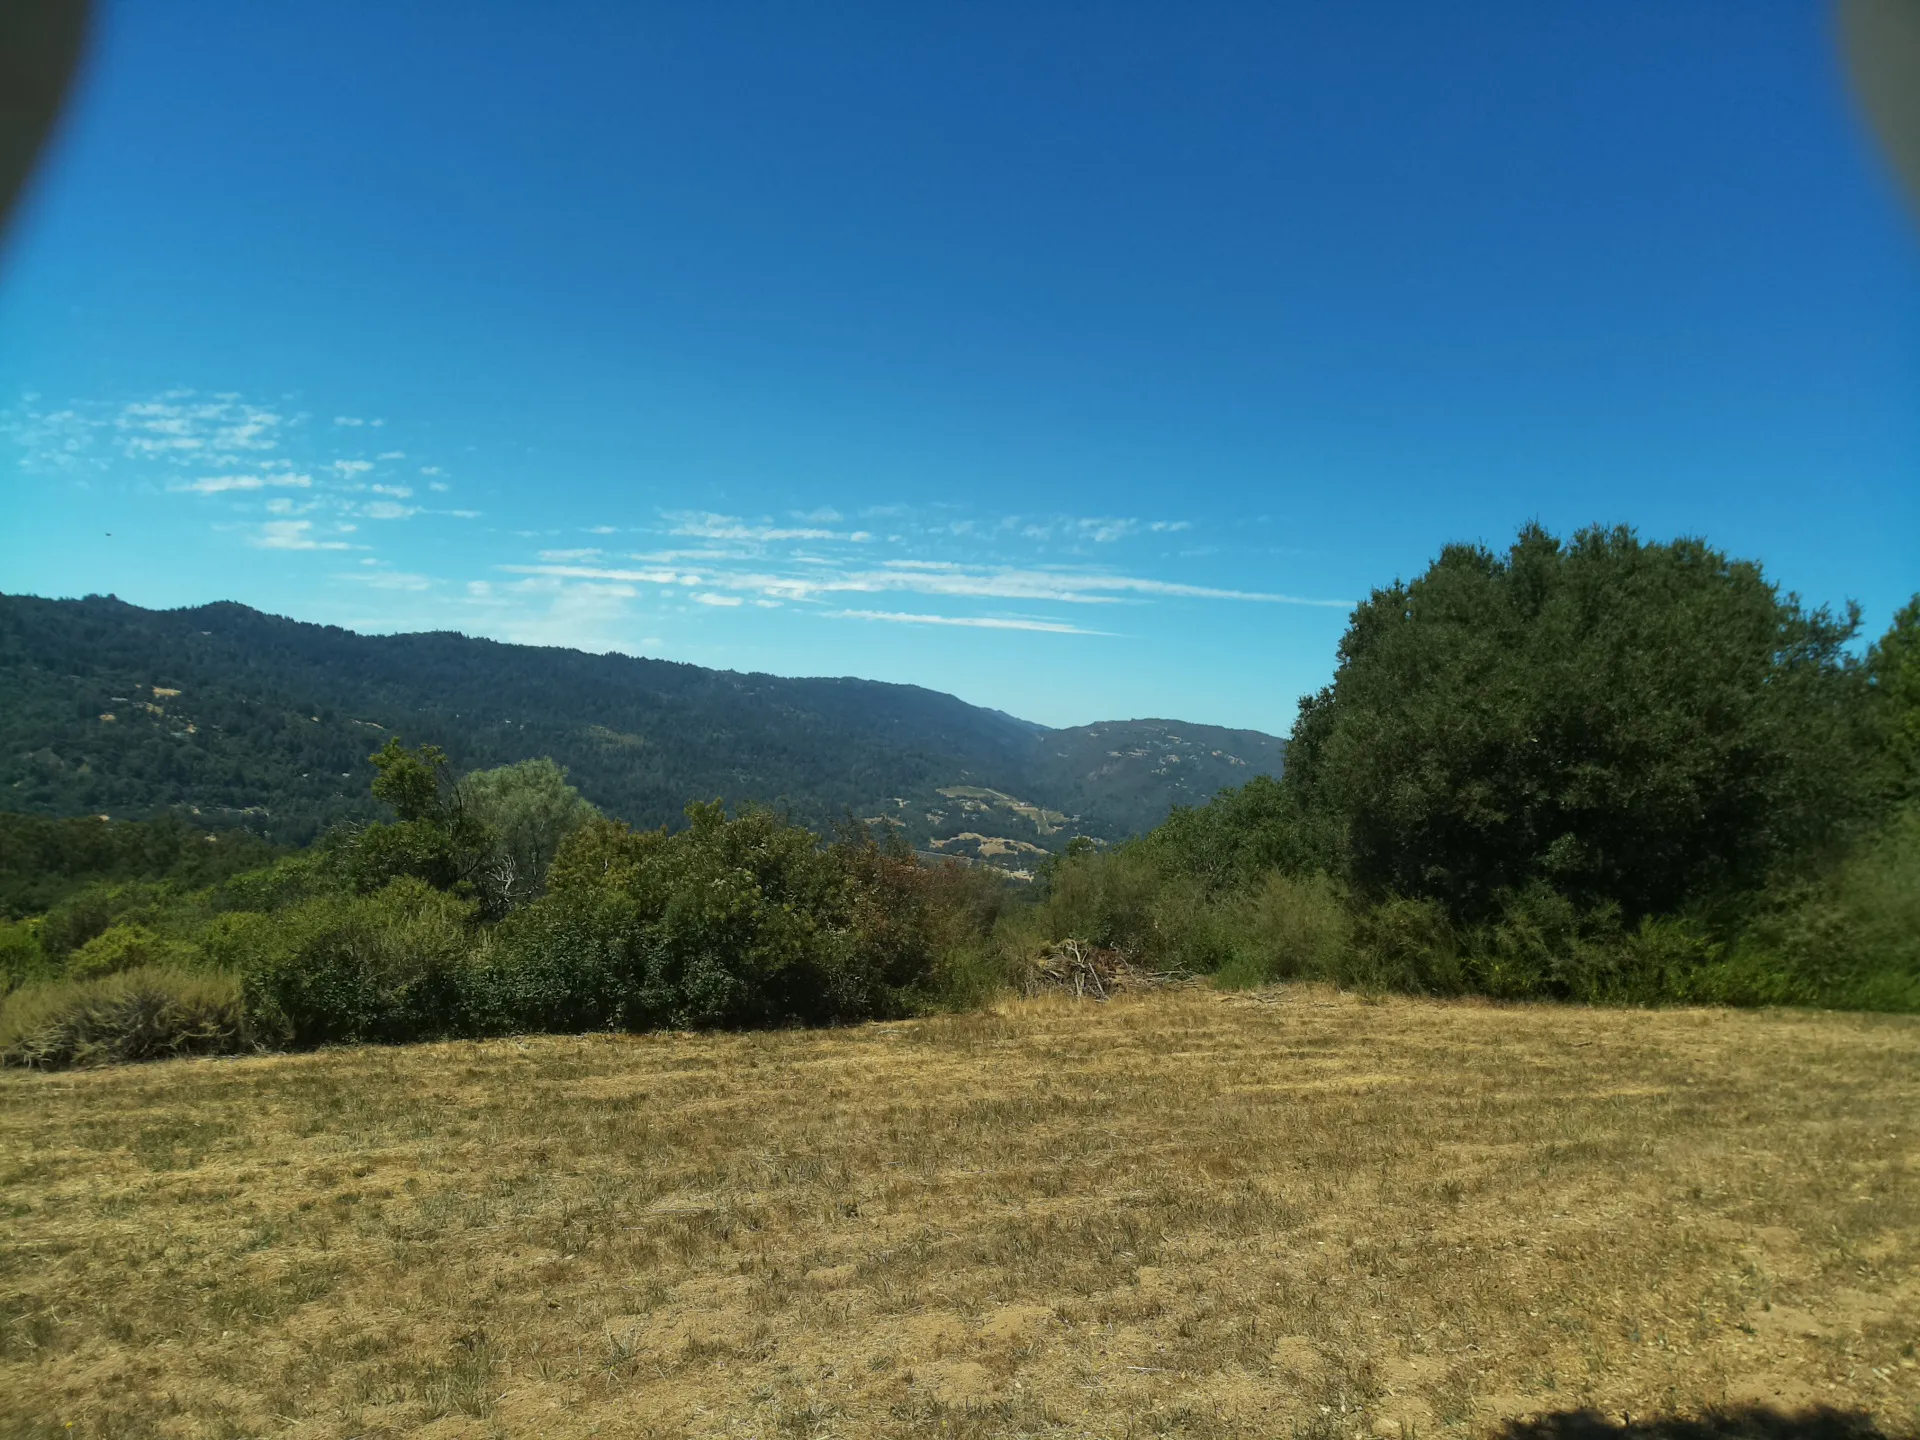

In [4]:
# Latest records organized by aliases
latest = session.get(f"{BASE_URL}/devices/{device_id}/latest").json()
print(f"Keys: {[e['alias'] for e in latest]}")
print(json.dumps(latest, indent=2))
latest_image_record = next((e['records'][0] for e in latest if e["alias"] == "camera_a" and len(e['records']) > 0), None)
if not latest_image_record:
    print("No image record found for this device's camera_a; Try another device or camera.")
else:
    image_url = f"{BASE_URL}/images/{latest_image_record['id']}"
    image_response = session.get(image_url)
    image_response.raise_for_status()
    display(IPyImage(image_response.content))

Collected 975 records via cursor pagination


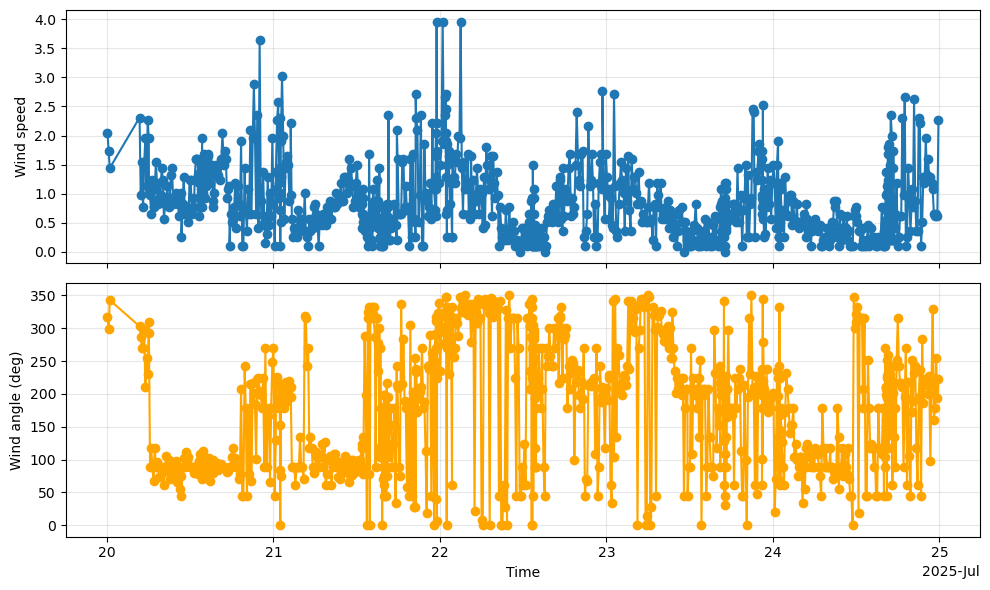

In [6]:
# Historical records by sensor (alias or number) and record type
from typing import Iterable


def iterate_records(
    device_id: str,
    sensor: Union[int, str],
    record_type: str,
    *,
    min_time: Optional[str] = None,
    max_time: Optional[str] = None,
    page_size: int = 100,
) -> Iterable[Dict[str, Any]]:
    """
    Cursor pagination with `olderThan` and `newerThan`

    * Records are always returned newest to oldest.
    * To walk toward older records: use `olderThan` with the id of the last item from the current page. Repeat each time with the new page's last id.
    * To walk toward newer records: use `newerThan` with the id of the first item from the current page. Repeat each time with the new page's first id.

    Using `olderThan`:

    ```
    [ newest ]  r1  r2  r3  r4  r5  r6  r7  [ oldest ]

    Request 1: no cursor                       -> r1 r2 r3
    Request 2: olderThan = id(r3)              -> r4 r5 r6
    Request 3: olderThan = id(r6)              -> r7 ...
    ```

    Using `newerThan`:

    ```
    [ newest ]  r1  r2  r3  r4  r5  r6  r7  [ oldest ]

    <At this point, r1, r2, r3, r4 don't exist yet>
    Request 1: no cursor                        -> r5 r6 r7

    <Waiting for those newer records to be available>
    <r1, r2, r3, r4 are added>
    Request 2: newerThan = id(r5); page=1       -> r1 r2 r3
    Request 3: newerThan = id(r5); page=2       -> r4
    ```

    """
    params = {}
    if min_time:
        params["minTimeRecorded"] = min_time
    if max_time:
        params["maxTimeRecorded"] = max_time
    if page_size:
        params["limit"] = page_size
    cursor: Optional[str] = None
    while True:
        response = session.get(
            f"{BASE_URL}/devices/{device_id}/sensors/{sensor}/{record_type}",
            params=params,
        )
        response.raise_for_status()
        data = response.json()["data"]
        if not data:
            break
        for item in data:
            yield item
        # Use the last record id as the next cursor
        cursor = data[-1].get("id")
        params["first"] = cursor


example_sensor = "wind"
example_record_type = "anemometer"
start_time = "2025-07-20T00:00:00Z"
end_time = "2025-07-25T00:00:00Z"

# Example: iterate a couple of pages using cursor 'last'
collected = []
for rec in iterate_records(
    device_id,
    example_sensor,
    example_record_type,
    min_time=start_time,
    max_time=end_time,
    page_size=100,
):
    collected.append(rec)

print(f"Collected {len(collected)} records via cursor pagination")


# Plot wind speed/angle over time if available
_times = []
_speeds = []
_angles = []
for _rec in collected:
    _ts = _rec.get("timeRecorded")
    _dt = datetime.fromisoformat(_ts.replace("Z", "+00:00"))
    _anemo = _rec.get("anemometer") if isinstance(_rec, dict) else None
    if _dt and isinstance(_anemo, dict):
        _speed = _anemo.get("speed")
        _angle = _anemo.get("angle")
        if isinstance(_speed, (int, float)) and isinstance(_angle, (int, float)):
            _times.append(_dt)
            _speeds.append(float(_speed))
            _angles.append(float(_angle))

if _times:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax1.plot(_times, _speeds, marker="o", linestyle="-")
    ax1.set_ylabel("Wind speed")
    ax1.grid(True, alpha=0.3)

    ax2.plot(_times, _angles, marker="o", linestyle="-", color="orange")
    ax2.set_ylabel("Wind angle (deg)")
    ax2.set_xlabel("Time")
    ax2.grid(True, alpha=0.3)

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.show()
